## Write and Read from/to tensorflow files
* example (testing) of read / write to tfrecords file

In [5]:
import glob
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
image_filenames = glob.glob('./imagenet-dogs/Images/n02*/*.jpg')[2:5]

In [7]:
from itertools import groupby
from collections import defaultdict

In [8]:
image_data = defaultdict(list)

In [9]:
image_filenames

['./imagenet-dogs/Images/n02085620-Chihuahua/n02085620_10621.jpg',
 './imagenet-dogs/Images/n02085620-Chihuahua/n02085620_1073.jpg',
 './imagenet-dogs/Images/n02085620-Chihuahua/n02085620_10976.jpg']

In [10]:
image_filename_with_breed = map(lambda x: (x.split("/")[3], x), image_filenames)

In [11]:
# add files to dicntionary
for dog_breed, breed_images in groupby(image_filename_with_breed, lambda x: x[0]):
        for i, breed_image in enumerate(breed_images):
            image_data[dog_breed].append(breed_image)            

In [12]:
# saving image to tfrecord file
record_location = './output/tf_write_test/serial_file'

sess = tf.Session()

record_filename = "{record_location}-{current_index}.tfrecords".format(
        record_location=record_location,
        current_index='fixed')
writer = tf.python_io.TFRecordWriter(record_filename)


for breed, images_filenames in image_data.items():
    for image_filename in images_filenames:        
        print image_filename[1]
        
        image_file = tf.read_file(image_filename[1])

        try:
            image = tf.image.decode_jpeg(image_file)
        except:
            print(image_filename)
            continue

        # convert to gray scale and resize images
        grayscale_image = tf.image.rgb_to_grayscale(image)        
        resized_image = tf.image.resize_images(grayscale_image, size = [250, 151])

        image_bytes = sess.run(tf.cast(resized_image, tf.uint8)).tobytes()            
        image_label = breed.encode('utf-8')        

        example = tf.train.Example(features=tf.train.Features(feature={
                    'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_label])),
                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))
                }))

        writer.write(example.SerializeToString())

writer.close()

./imagenet-dogs/Images/n02085620-Chihuahua/n02085620_10621.jpg
./imagenet-dogs/Images/n02085620-Chihuahua/n02085620_1073.jpg
./imagenet-dogs/Images/n02085620-Chihuahua/n02085620_10976.jpg


In [13]:
# one pixe = one byte in gray scale 
len(image_bytes)

37750

(250, 151, 1)


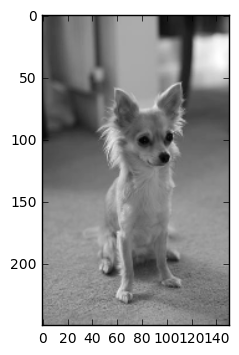

In [14]:
# example of how the image is being changed w
print sess.run(resized_image).shape
s = sess.run(resized_image).shape
im = sess.run(resized_image)
im = im.reshape(s[0], s[1])
plt.imshow(im, cmap='gray')

***

## Reading Files from 

In [15]:
file_list = tf.train.match_filenames_once("./output/tf_write_test/*.tfrecords")
sess = tf.Session()
sess.run(tf.initialize_all_variables())
sess.run(file_list)

array(['./output/tf_write_test/serial_file-fixed.tfrecords'], dtype=object)

In [16]:
filename_queue = tf.train.string_input_producer(
    tf.train.match_filenames_once("./output/tf_write_test/*.tfrecords"))

In [17]:
reader = tf.TFRecordReader()
key, value = reader.read(filename_queue)

features = tf.parse_single_example(
#features = tf.parse_example(
    value,
    features={
        'label':tf.FixedLenFeature([], tf.string),
        'image':tf.FixedLenFeature([], tf.string)
    })

image = tf.reshape(tf.decode_raw(features['image'], tf.uint8), [250,151,1])
label = tf.cast(features['label'], tf.string)

In [18]:
min_after_dequeue = 10
batch_size = 3
capacity = min_after_dequeue + 3 * batch_size

In [26]:
output = []
with tf.Session() as sess:
    
    sess.run(tf.initialize_all_variables())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(5):
        output.append(sess.run([image]))    

    coord.request_stop()
    coord.join(threads)

In [27]:
len(output)

5

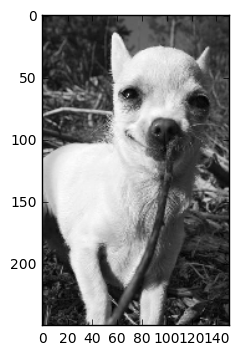

In [33]:
plt.imshow(output[4][0].reshape(250,151), cmap='gray')